LOADING THE ELECTRICITY DEMAND DATA

In [ ]:
import pandas as pd
import glob
from datetime import timedelta

#path to the drive folder
path = "Demand_data"
#instruction for all files in the folder that end with csv to be appended onto a list using the glob module
all_csv_files = glob.glob(path + "/*.csv")
#creating empty demand list onto which we will add the read csv files as individual lists of files, imagine like in a drawer
demand_list = []

#loop to read through all the filenames that we have created using glob module - those that end with csv
for filename in all_csv_files:
    #reading individual csv file in each cycle
    df = pd.read_csv(filename, index_col=None, header = 0)
    #extract that specific's file first settlement date as the start date - using iloc
    date = pd.to_datetime(df['SETTLEMENT_DATE'].iloc[0])
    #create an empty list onto which we will be appending all the generated timestamps
    timestamps = []
    #for loop to generate the timestamps of corresponding length to the dataframe and in timesteps of 30 minutes then append that data to the timestamps list
    for i in range(0, len(df)*30, 30):
      timestamps.append(date + timedelta(minutes=i))
    #adding the new timestamps lists as an extra column for time identification in the new dataframe
    df['date'] = timestamps
    #appending the new dataframe (with each cycle) into the list of the dataframes
    demand_list.append(df)

#Now concatenate all the lists into one dataframe
df_demand = pd.concat(demand_list, axis = 0, ignore_index=True)

#Filter for only pre-covid demand
df_demand = df_demand[df_demand['date'] < '2020-01-01 00:00:00']
df_demand = df_demand[df_demand['date'] > '2014-12-31 23:30:00']

#Reset the index to identify the split points better later
df_demand = df_demand.reset_index(drop = True)

#Terminal prints to confirm filtered dataframe start and end dates
print(f'First day:', df_demand['date'].iloc[0])
print(f'Last day:', df_demand['date'].iloc[-1])
print(f'dataframe length:', len(df_demand))


EXTRATING AND ADJUSTING THE DEMAND DATA FOR MODEL PREPARATION

In [ ]:
import numpy as np
from numpy import array

#extract demand data from dataframe and convert it into a Gigawatt list (157776 elements)
demand = list(map(float, (df_demand['ND']/1000)))

#Terminal print to confirm list same length as dataframe and data in GW instead of MW
print(f'demand data length:', len(demand))
print(f'first ten demand elements in GW before normalisation:', demand[:10])
print(f'last ten demand elements in GW before normalisation:', demand[-10:])

Subsection: Identify the split point

In [ ]:
#First three years for training ('15, '16, 17)
split_point_one = df_demand[df_demand['date'] == '2016-01-01 00:00:00'].index[0]

#'18 set aside as the valudation set and 2019 for the test set
split_point_two = df_demand[df_demand['date'] == '2017-01-01 00:00:00'].index[0]

#'18 set aside as the valudation set and 2019 for the test set. Just for quick testing
split_point_three = df_demand[df_demand['date'] == '2018-01-01 00:00:00'].index[0]

#Terminal print to confirm split points
print(f'The split point is at index', split_point_one, 'while the second one is:', split_point_two)
print(f'the third split point is', split_point_three)

Subsection: perform the split

In [ ]:
#apply that split point on the list of demand data careful to include the slight overlap in test set to ensure no skip in predictions
#set the training window - 2 weeks (2 weeks *7 days *48 settlement period) input to map out to one day output (48 settlement periods)
n_steps = 2*7*48
train, val, test = demand[0:split_point_one], demand[(split_point_one - n_steps):(split_point_two)], demand[(split_point_two - n_steps):split_point_three]
print(f'Training set length is', len(train), 'validation set is:', len(val),'while test set length is', len(test))

Subsection: normalising the data using the minmax scaler algorithm. Note that I tried running without normalisation and the model training quickly runs into a nan loss within the first few training batches. Also, the other program file explores the use of the standard scaler as an alternative. Normalisation temporarily excluded

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# define min max scaler object
scaler = MinMaxScaler()

# fit data. This identifies the max/ min demand and computes the mean and standard deviation to be used by all the other transformations
print(scaler.fit(np.array(train).reshape(-1, 1)))

#Terminal print to identify what the maximum demand in the training set was
print(scaler.data_max_)

#Now that we have identified, we perform the tranform but the data needs to be converted from list to array then reshaped
train = scaler.transform(np.array(train).reshape(-1, 1))
print(train.shape)

#Since we reshaped the data to a single stretching column, we now reconvert that to a horizontal array
train = train.reshape(-1)
print(f'First 5 elements of transformed training data:', train[0:5])

#Transforming the validation data
val = scaler.transform(np.array(val).reshape(-1,1))
print(val.shape)

#Reconverting validation data to a horizontal array again
val = val.reshape(-1)
print(f'First 5 elements of transformed validation data:', val[0:5])

Now creating the function to reshape the data before feeding it into the model

In [6]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
 #loop through the list and update the days so that instead of sliding the window across one point, its across 48 points (one day)
	for i in range(0, len(sequence), 48):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-48:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix: end_ix+48]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

Subsection: reshape training data for the model

In [ ]:
X_train, y_train = split_sequence(train, n_steps)

#Useful to understanding the new shaping
print('X_train data')
print('------------')
print(X_train.shape)
print(len(X_train[0]))
print(X_train[0][0:6])

print('y_train data')
print('------------')
print(y_train.shape)
print(len(y_train[0]))
print(y_train[0][0:6])

Subsection: reshape the validation data

In [ ]:
X_val, y_val = split_sequence(val, n_steps)

#Useful to understanding the new shaping
print('X_val data')
print('------------')
print(X_val.shape)
print(len(X_val[0]))
print(X_val[0][0:6])

print('y_val data')
print('------------')
print(y_val.shape)
print(len(y_val[0]))
print(y_val[0][0:6])

Subsection: reshaping the training set

In [9]:
#univariate hence n_features = 1
n_features = 1
#This reshapes the data such that if you imagine you are staring at a screen:
#n_features is the number of vertical lines you can draw on that screen
#X_train.shape[1], in this case, 672,is the number of lines you could draw from left to right on the same screen
#X_train.shape[0], in this case 1082 (the number of batched samples) is the number of lines you could draw into or out of the screen
#If you imagine the screen that you are facing being pushed to your right, almost like into a slot, then what we have done is reshape the data
#such that the past 672 demand points are written vertically and being pushed as one long vertical line into the slot and will be mapped to the 48 we have on the other end
#This mapping will happen 139537 times in cycle (epoch) during which the model will try to identify any patterns.
#The learning is then repeated across several epochs
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
print(f'the new x_train shape for the model is', X_train.shape)

the new x_train shape for the model is (351, 672, 1)


Subsection: building the autoregressive model. Note that I had to lower the learning rate by 10 factor 3 (default is 0.0001) to avoid the training running into infinite then nan loss values (which before, was happening by the time we got to the 30th of 4361 batches). I also added the clipvalue to try prevent the same but might be worthwhile to see how the model would perform if we were to remove it.

Updated to include the live plotting

In [ ]:
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from IPython.display import clear_output
from bayes_opt import BayesianOptimization

#CREATING DATAFRAME TO SAVE RELEVANT RESULTS
results_df = pd.DataFrame(columns=["Iteration", "Start Time", "End Time", "unit1", "unit2", "drop1", "drop2", "learn_rate", "step1", "step2", "step3", "rate1", "rate2", "rate3", "Train Loss", "Val Loss", "Train MSE", "Val MSE"])

#SET UP TRAINING PARAMETERS

# Function to calculate root mean squared error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#set batch_size
batch_size = int(X_train.shape[0]/8)
print(f'Batch size:', batch_size)

def optimize_lstm(unit1, drop1,unit2,drop2,learn_rate,step1,rate1,step2,rate2, step3, rate3):

    #These are some of the hyperparameters that we will be adjusting using bayesian optimisation, though some of them are, actually, parameters in that they stay constant throughout the exploration process. Example, the intial learning rate
    unit1 = int(unit1)
    unit2 = int(unit2)
    step1 = int(step1)
    step2 = int(step2)
    step3 = int(step3)
    initial_learning_rate = learn_rate
    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay([step1, step2, step3], [learn_rate, rate1,rate2,rate3])
    #What this is saying is this, take, for example, the first iteration being step1   (0,500), learn_rate1(0.0005) - which is now the initial learning rate and rate1(0.0001, 0.001). This is saying that for the first 0th iteration, train with initial learning rate - 0.0005, for the next 500 iterations, train with first element of rate1 - 0.0001 and for the remainder, train with the new rate - 0.001. Include link (ChatGPT Optimising hyperparameter note folder)

    #Here we define the start time
    start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime())


    #This is where we build the actual model. Note unit1 is first_layer_neuron_size, drop_1 is dropout_rate for first dropout layer, unit2 is the number of neurons in the second bidirectional lstm layer then drop2 is the dropout rate for the second dropout layer. So we are adjusting layer1, rate1, layer2,rate2
    model = Sequential([
        tf.keras.layers.Bidirectional(LSTM(unit1, return_sequences = True, input_shape = (n_steps, n_features))),
        tf.keras.layers.Dropout(drop1),
        tf.keras.layers.Bidirectional(LSTM(unit2, return_sequences = False)),
        tf.keras.layers.Dropout(drop2),
        tf.keras.layers.Dense(48)
    ])

    #Now these are some of the training parameters to reduce on the training time. We are telling the model that for each training period, stop once you get to a point where even after 100 consecutive trainings, there is no change in the validation loss
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 100)

    #This is now where we bring everything together into the model. First, we built the model architecture, then we defined a few other things to optimise the training such as early stopping then now we bring everything together with compile saying:
    #when training the model, use Adam optimiser to find the best weights, use the following learning rate schedule
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule), loss = root_mean_squared_error, metrics = ['mse'])
    model.build(input_shape = (None, n_steps, n_features))

    history = model.fit(x = X_train,
                        y = y_train,
                        verbose = 2, #just want to see the epoch and the training/ validation losses. Don't care about time logs yet
                        batch_size = batch_size,
                        epochs = 5000,
                        validation_data = [X_val, y_val],
                        callbacks = [early_stop]
                        )

    #Obtaining all the results and saving them to a dictionary
    iteration_results = {
        "Iteration": len(results_df) + 1,
        "Start Time": start_time,
        "End Time": time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()),
        "unit1": unit1,
        "unit2": unit2,
        "drop1": drop1,
        "drop2": drop2,
        "learn_rate": learn_rate,
        "step1": step1,
        "step2": step2,
        "step3": step3,
        "rate1": rate1,
        "rate2": rate2,
        "rate3": rate3,
        "Train Loss": history.history["loss"][-1],
        "Val Loss": history.history["val_loss"][-1],
        "Train MSE": history.history["mse"][-1],
        "Val MSE": history.history["val_mse"][-1]
    }

    # Append iteration results to results_df
    results_df.loc[len(results_df)] = iteration_results

    # Save results to CSV after each iteration
    results_df.to_csv('Bayesian_BiLSTM_analysis.csv', index=False)

    best_val_loss = min(history.history['val_loss'])

    return -best_val_loss


#Dictionary to store the boundaries probably. Note that the way the Bayesian optimiser works is not discrete like with the talos gridsearch option. This is almost continuous
p_bounds = {
    'unit1':(20,128), #first layer neurons - from 1 to 100
    'unit2': (20,256),#second layer neurons - from 1 to 100
    'drop1': (0.05,0.5), #first dropout rate - from 0.05 to 0.5
    'drop2': (0.05,0.5), #second dropout rate
    'learn_rate': (0.0005, 0.005), #there are two initial learning rates. First, start with 0.0005 and follow the schedule. Then restart with 0.005 and follow the schedule
    'step1': (10, 500),
    'step2': (1000, 2000),
    'step3': (2000, 5000),
    'rate1': (0.0001, 0.001),
    'rate2': (0.00005, 0.0005),
    'rate3': (0.000005, 0.00005)
}

#create an object for the optimiser
optimizer = BayesianOptimization(f = optimize_lstm, pbounds = p_bounds, random_state = None, verbose = 2)

#Then apply the .maximize method
#This will generate 15 different sets of hyperparameters in the beginning (init_points)
#Later, it will select a new set of hyperparameters (16th) using the surrogate model and keep doing this another 14 more times (n_iter = 15). In total, this model will run 30 iterations and the results will be saved into the dataframe that I created up there.
optimizer.maximize(init_points = 15, n_iter = 15)


#print(optimizer.max) We will add this later on. Also, since we are tracking rmse, don't we want the min? Worth thinking about

In [67]:
#%matplotlib #to introduce interactive plots

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

class Visualiser:
  def __init__(self):
    '''Initialising something here means that you can update it easily if one/ more of the methods are
    linked to it by stating return self.df or if it is declared anywhere in the methods
    This is such that other methods can access it directly. It is not a global
    variable but it becomes an overall instance attribute which can then be used by any method.
    Care must be taken since it might be difficult to track errors introduced
    especially when a subsequent method was supposed to use, for example,
    a column in the dataframe yet the self.df was last updated by another method which removed that column
    As such, I will leave self.df to be the one returned by the
    load_csv method and then for all the other methods,
    I will just call the load_csv method inside the new method'''

    self.df = None #init as none, update once csv loaded, add duration column
    #self.corr_df = None #init as none, update once correlation_matrix_generator is run


  def load_csv(self, filepath):
    '''Loads the csv file and computes the duration in hours then appends this as the last column in the dataframe
    Input - filepath in quotation marks (as a string)
    Output - the dataframe which is saved both at the method instantiation and updated at the attribute instantiation under the __init__'''


    #Reads the csv following the provided path
    self.df = pd.read_csv(filepath)


    #Converts the start and end time columns to datetime format, computes the difference to get the duration in seconds and divides by 3600 to convert that to hours
    self.df['Duration_hrs'] = (pd.to_datetime(self.df['End Time']) - pd.to_datetime(self.df['Start Time'])).dt.total_seconds()/3600


    #Returning self.df updates the df instantiated at the init point
    return self.df

  def correlation_matrix_generator(self, number, display_heatmap = True):
    '''
    Checks if csv file is loaded by looking into the self.df attribute declared at the __init__ constructor. If loaded and depending on user input (which constitutes indices of columns to be dropped), deletes columns, generates new (model architecture ratio-ed) columns and generates a correlation matrix of the remaining columns. Maps the exact correlation matrix into a correlation dataframe and drops the y-axis matrix label such that instead of column names, its replaced with integer values. Additionally, maps the original correlation matrix into a heatmap using sns and displays this using matplotlib's pyplot

    Input: self.df dataframe once loaded. A list of the columns that the user wants to delete. If just one column, enter that column number as a list i.e., with square brackets e.g., [2] for column 2

    Output: 
    On automatic display - the correlation heatmap
    Held by the method - correlation dataframe and the new_df dataframe which is similar to the original df dataframe but with deleted (depending on user input) and added ratio-ed columns
    '''
    if self.df is not None:
      #Dropping columns as per user input list. Note that Setting inplace = True modifies the dataframe in place but returns a new and empty dataframe. Solution. Either setting inplace = False or have the function not return anything such that it is the original dataframe that is still being used
      new_df = self.df.drop(self.df.columns[number], axis = 1, inplace = False) 


      #Adding extra columns to the dataframe for detailed correlation
      new_df['u1:u2'] = new_df['unit1']/new_df['unit2'] #layer1size: laye2size
      new_df['d1:d2'] = new_df['drop1']/new_df['drop2'] #rate1:rate2
      new_df['u1d1:u2d2'] = (new_df['unit1']*new_df['drop1'])/(new_df['unit2']*new_df['drop2']) #combined ratio for layer1*rate1:layer2*rate2


      #Generate the correlation matrix
      corr_matrix = new_df.corr()

      #Then we generate a correlation dataframe as well to be used in the next method

      #Start by extracting the column names and saving to a list
      column_names = new_df.columns.to_list()
            # Then combine column names and correlation matrix to form dataframe. Note that by not setting index to anything, we are only picking the matrix data and the column names to make a dataframe equivalent of the matrix. Also, note that we are using self.corr_df because we want to update the corr_df at the __init__ point
      corr_df = pd.DataFrame(corr_matrix, columns = column_names)


      #Then we move to visualise the overall correlation matrix. Note that we add the display_heatmap at the argument level and set it to True initially. This is to allow for us to control when the matrix is to be printed out on the terminal as we don't want it printed out all the time - useful for the next method.
      if display_heatmap:
        #Create correlation heatmap size using matplotlib
        fig, ax = plt.subplots(figsize = (10,8))


        #Then create the correlation heatmap
        sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', linewidths = 0.5, ax = ax)

        #Set the correlation heatmap title
        ax.set_title('Overall correlation matrix')

        #Display the correlation heatmap
        plt.show()

      #We now have our function holding the correlation dataframe and the new dataframe (with all the irrelevant columns deleted).
      return corr_df, new_df

    else:
      print('Data not loaded yet, please provide csv file')
      pass



    
  def top_correlation_indices(self, number, target_variable, top_n, display_heatmap = False):
    '''While the correlation_matrix_generator method shows us an overall picture of the different correlation indices, this method allows for us to quickly look through the correlation dataframe (from previous method) and identify the variables that have the greatest influence on our target variable. Note that this checks if the corr_df attribute has been updated by the correlation_matrix_generator hence important to run that method before running this one.
    
    Input - corr_df from previous method, the target variable that we want to monitor (enter as the column name in quotes - a string) and the number of top values you want to consider as int e.g., if you want to see the top three indices, enter 4 since it ignores the first correlation index (of value 1) as this is self-correlation in the matrix
    
    output - a list of the top variables strongly correlated with the target variable and with their corresponding correlation indices'''


    corr_df, _ = self.correlation_matrix_generator(number, display_heatmap)
    column_names = corr_df.columns.to_list()

    #Convert the column to a list with indices (which would correspond to the row number)
    target_variable_as_list = corr_df[target_variable].to_list()


    #Sorts the variables in descending order starting with the highest. In this case, the highest correlation index is self correlation (1.0) with index 3 hence on row number 3
    sorted_indices = np.argsort(np.abs(target_variable_as_list))[::-1]



    #Picks up the highest ignoring the first (self correlation). This is a list of the corresponding indices and not the correlation value itself. Note that to avoid confusing the user, we do n+1 to account for the ignored (original) first index - the self correlated one
    top_indices = sorted_indices[1:top_n+1]


    #Then set up the for loop to retrieve the actual tags associated with the correlation
    print(f'The {top_n} most influential variables for {target_variable} and their corresponding correlation indices are:')
    for index in top_indices:
      variable_name = column_names[index]
      correlation_value = target_variable_as_list[index]
      print(f'{variable_name}: Correlation:{correlation_value:.4f}')




    return
  


  def line_plot(self, number, variable, target_variable, display_heatmap = False):

    #Retrieving the dataframe from the self.correlation_matrix_generator and saving that to results_df dataframe while dropping columns and suppressing heatmap
    _, results_df = self.correlation_matrix_generator(number, display_heatmap)

    #Since values not arranged in increments/ decrements, sort them out first
    results_df = results_df.sort_values(by = variable)

    #Extracting the relevant columns depending on user input
    var_values = results_df[variable]
    target_values = results_df[target_variable]

    #Plotting the results on a line graph
    # Assuming you have your data loaded in a DataFrame named 'results_df'

    plt.figure(figsize=(10, 6))
    plt.plot(var_values, target_values, marker='o')
    plt.title('Effect of ' + variable + ' on ' + target_variable)
    plt.xlabel(variable + ' values')
    plt.ylabel(target_variable)
    plt.grid(True)
    plt.show()


  def scatter_plot(self, number, variable, target_variable, display_heatmap = False):

    #Retrieving the dataframe from the self.correlation_matrix_generator and saving that to results_df dataframe while dropping columns and suppressing heatmap
    _, results_df = self.correlation_matrix_generator(number, display_heatmap)

    #Since values not arranged in increments/ decrements, sort them out first
    results_df = results_df.sort_values(by = variable)

    #Extracting the relevant columns depending on user input
    var_values = results_df[variable]
    target_values = results_df[target_variable]

    # Calculate the best-fitting line coefficients using numpy.polyfit()
    line_coefficients = np.polyfit(var_values, target_values, 1)  # 1 specifies a linear fit rather than a polynomial one in case the data implies so

    #Then we use polyval to generate the equation of the line using these datapoints and their corresponding y's (var_values).
    best_fit_line = np.polyval(line_coefficients,var_values)

    #Plotting the results on a line graph
    # Assuming you have your data loaded in a DataFrame named 'results_df'

    plt.figure(figsize=(10, 6))
    plt.scatter(var_values, target_values, marker='o')
    plt.plot(var_values, best_fit_line, color = 'red', label = 'best fit line')
    plt.title('Effect of ' + variable + ' on ' + target_variable)
    plt.xlabel(variable + ' values')
    plt.ylabel(target_variable)
    plt.grid(True)
    plt.show()
    
  
  def two_D_contour_plot_(self, number, variable_1, variable_2, target_variable, display_heatmap = False):
    
    #obtaining the new_df from the correlation_matrix_generator method to be used for plotting. Note that to do this, we need to provide all the arguments that the previous method would require at the start of our new method then feed that into our initial method at the point when we create it e.g., we want to suppress the heatmap thus we set it to false. Additionally, the correlation_matrix_generator method returns two outputs - corr_df and new_df. We use _ to suppress the first and obtain the second instead as results_df. Also note that the order of the input variables for this method have to match when we call the function i.e., if our first argument when callig the method was 'variable_1' the method would return an error since it expects for this to be the number.
    _, results_df = self.correlation_matrix_generator(number, display_heatmap)
    var1_values = results_df[variable_1]
    var2_values = results_df[variable_2]
    target_var_values = results_df[target_variable]

    # Create a grid of unit1 and unit2 values
    var1_range = np.linspace(min(var1_values), max(var1_values), 100)
    var2_range = np.linspace(min(var2_values), max(var2_values), 100)
    var1_grid, var2_grid = np.meshgrid(var1_range, var2_range)

    # Interpolate validation loss values onto the grid
    target_var_grid = griddata((var1_values, var2_values), target_var_values, (var1_grid, var2_grid), method='linear')

    # Create the contour plot
    fig, ax = plt.subplots(figsize=(10, 8))
    contour = ax.contourf(var1_grid, var2_grid, target_var_grid, levels=20, cmap='viridis')
    cbar = plt.colorbar(contour, ax=ax)
    cbar.set_label(target_variable)

    ax.set_xlabel(variable_1 + ' values')
    ax.set_ylabel(variable_2 + ' values')
    ax.set_title('Contour Plot of ' + target_variable + ' vs. ' + variable_1 + ' and ' + variable_2)


    plt.show()

  def three_D_contour_plot_(self, number, variable_1, variable_2, variable_3, target_variable, display_heatmap = False):
    
    #obtaining the new_df from the correlation_matrix_generator method to be used for plotting. Note that to do this, we need to provide all the arguments that the previous method would require at the start of our new method then feed that into our initial method at the point when we create it e.g., we want to suppress the heatmap thus we set it to false. Additionally, the correlation_matrix_generator method returns two outputs - corr_df and new_df. We use _ to suppress the first and obtain the second instead as results_df. Also note that the order of the input variables for this method have to match when we call the function i.e., if our first argument when callig the method was 'variable_1' the method would return an error since it expects for this to be the number.
    _, results_df = self.correlation_matrix_generator(number, display_heatmap)
    # var1_values = results_df[variable_1]
    # var2_values = results_df[variable_2]
    # var3_values = results_df[variable_3]
    # target_var_values = results_df[target_variable]
    a = results_df[variable_1]
    b = results_df[variable_2]
    c = results_df[variable_3]
    d = results_df[target_variable]

    # Create a meshgrid for visualization
    a_grid, b_grid = np.meshgrid(np.linspace(min(a), max(a), 50), np.linspace(min(b), max(b), 50))

    # Interpolate values of c and d on the meshgrid
    c_interp = griddata((a, b), c, (a_grid, b_grid), method='nearest')
    d_interp = griddata((a, b), d, (a_grid, b_grid), method='nearest')

    # Create a figure
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the wireframe
    wireframe = ax.plot_wireframe(a_grid, b_grid, d_interp, cmap='viridis')

    # Add color bar
    cbar = plt.colorbar(wireframe)
    cbar.set_label('d')

    # Set labels and title
    ax.set_xlabel('a')
    ax.set_ylabel('b')
    ax.set_zlabel('d')
    ax.set_title('4D Wireframe Plot')

    # Show the plot
    plt.tight_layout()
    plt.show()  





#INSTANTIATING AND USING THE VISUALISER CLASS

#create class object
vis_obj_inst = Visualiser()

#print out the df property/ attribute/ class variable for the vis_obj instance. Since initially set to None and the load_csv method not called yet, should print none
print(vis_obj_inst.df)

UsageError: unrecognized arguments: introduce interactive plots


IN THIS NEXT SECTION, WE START TO USE THE CLASS TO PERFORM DIFFERENT ANALYTIC FUNCTIONS. THE NUMBERED MARKDOWNS HIGHLIGHT WHAT THE STEP IS ABOUT WHILE THE UN-NUMBERED ONES ARE NOTES ABOUT THE OBSERVATIONS MADE WHEN THE METHOD WAS CALLED ON THE CLASS INSTANCE

A) Calling the load_csv method from visualiser class on the vis_obj_inst instance to load the csv file with file path as input. Note that the semi colon at the end suppresses terminal output from being displayed

In [68]:
vis_obj_inst.load_csv('Bayesian_BiLSTM_analysis.csv');

B) Calling the correlation_matrix_generator method from visualiser class on the vis_obj_inst to prepare the loaded csv and return the correlation matrix for the various model variables. Note that we are first calculating the training duration in hours then deleting columns that we don't need. Display previous output (by removing the colon) to make sense of removed columns (columns start from index 0)

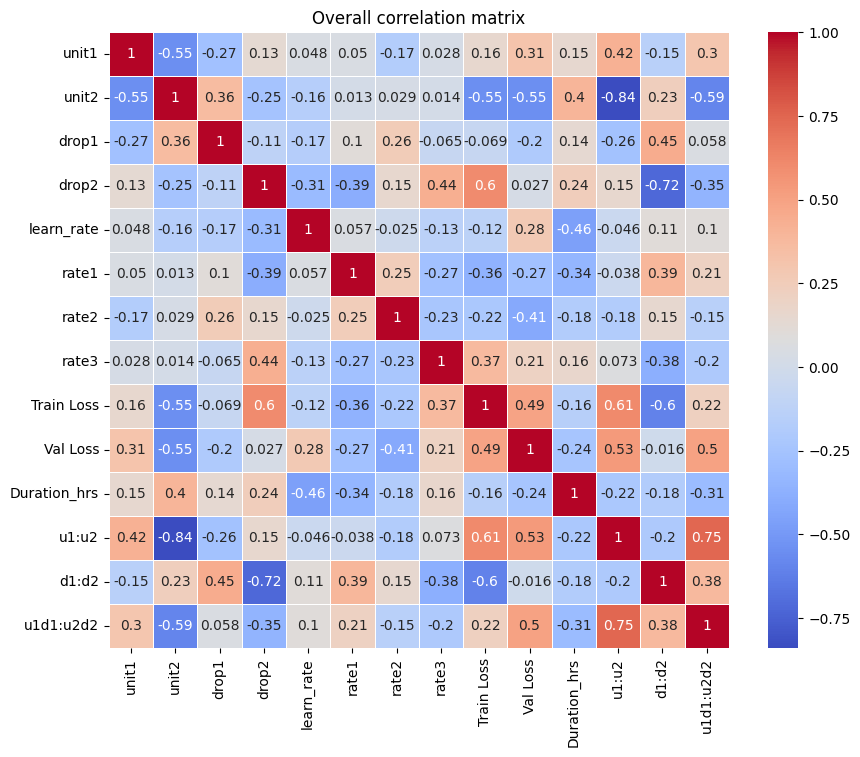

In [69]:
col_to_drop = [0,1,2, 8,9,10, -2, -3]
vis_obj_inst.correlation_matrix_generator(col_to_drop);

Quick notes when I scan the matrix along the training loss:
1. An increase in drop2 has a greater positive influence (0.72) on the training loss i.e., increase drop2, increase train loss. If our aim is to minimise training loss, then we better minimise drop2. This is insignificant for the validation loss though
2. Unlike drop2, drop1 has less influence on training loss. However, the ratio of d1:d2 has a great negative influence on training loss i.e., as we increase the ration (we make drop out rate 1 bigger than that of 2), we reduce on the training loss. However, this does not affect the validation loss where it seems like the ratio does not matter (correlation index -0.094, almost 0)
3. The training duration is mostly affected by the learning rate such that the higher the initial learning rate, the less the time it takes for the model to train. Additionally, as we move across the different timesteps (with reducing learning rate), the less influence the learning rate has on duration i.e., to understand how long the training will take, it is best to focus on the initial and step 1 learning rate. The higher these two are, the less the time the model takes to train after which the learning rate has less influence
4. Model size has a significant influence on the performance. First, unit2 seems to have a greater negative influence on both the training and validation loss such that as we increase the size of the second layer, we reduce both the training and validation loss (with more effect being realised at the training than at the validation point). Additionally, the ratio between layer1 and layer2 sizes matters positively for both training and validation in that as we increase the ratio (as we make layer1 bigger than layer2), we increase the loss. This is felt more with the training than with validation data. This implies that if we want to minimise the model loss (hence improve its accuracy), we want to equally minimise the layer1:layr2 ratio by making layer 1 equal to or smaller than layer 2. Essentially, we want to increase layer 2 size and reduce layer 1 size so that we have that outward pointing funnel
5. The top four most significant influences on both training and validation loss are: unit1, unit2 and their ratio to each other, drop1, drop2 and their ratio. Though, looking back into it, some of these affect training loss more than validation loss. If you want one that affects both of them equally strongly, you have u1:u2 ratio, unit2, rate1 and rate3 in that order

C) Calling the top_correlation_indices method from visualiser class on the vis_obj_inst to quickly visualise the top influencing drivers for the variable/ metric of choice. Input variable is a string of the variable that we want to focus on. The second argument is the number of the top key variables we want to see beginning with the most influential. Note that to run this, one must first run the correlation_matrix_generator method which prepares the correlation dataframe (corr_df)

In [70]:
vis_obj_inst.top_correlation_indices(col_to_drop,'Train Loss', 8)

The 8 most influential variables for Train Loss and their corresponding correlation indices are:
u1:u2: Correlation:0.6052
d1:d2: Correlation:-0.6046
drop2: Correlation:0.6021
unit2: Correlation:-0.5499
Val Loss: Correlation:0.4935
rate3: Correlation:0.3726
rate1: Correlation:-0.3598
rate2: Correlation:-0.2187


D) Now we explore how a singular variable affects the model performance (if in any way)

D1) Calling the line_plot method from visualiser class on the vis_obj_inst to quickly visualise how a singular variable affects the overall model performance. We first start with how unit1 affects the resulting train loss. When run, it seems like there is no direct influence - doesn't follow a straight line. So we go and check unit 2 instead

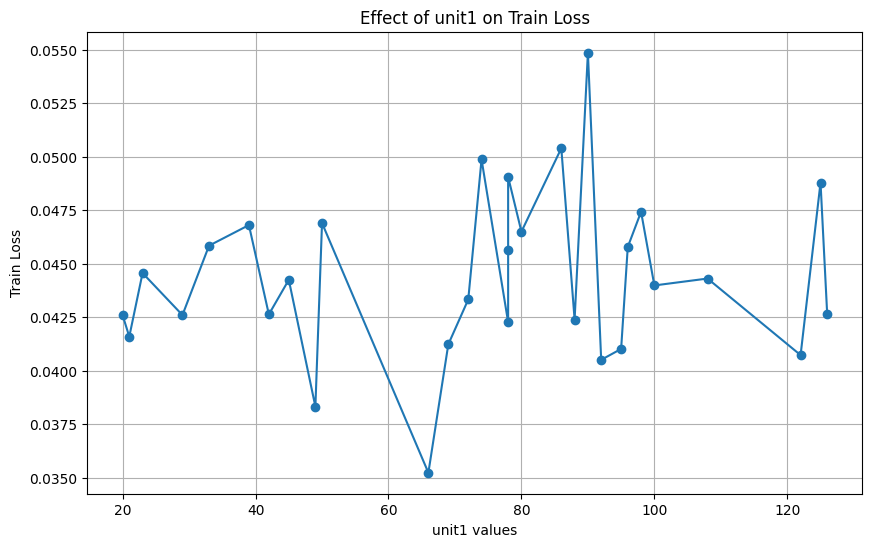

In [71]:
vis_obj_inst.line_plot(col_to_drop, 'unit1', 'Train Loss')

D2) Calling the line_plot method from visualiser class on the vis_obj_inst to quickly visualise how a singular variable affects the overall model performance. We now check unit2 and how it affects the train loss. Again, when run, it seems like there is no direct influence hence try see how these two would work best together

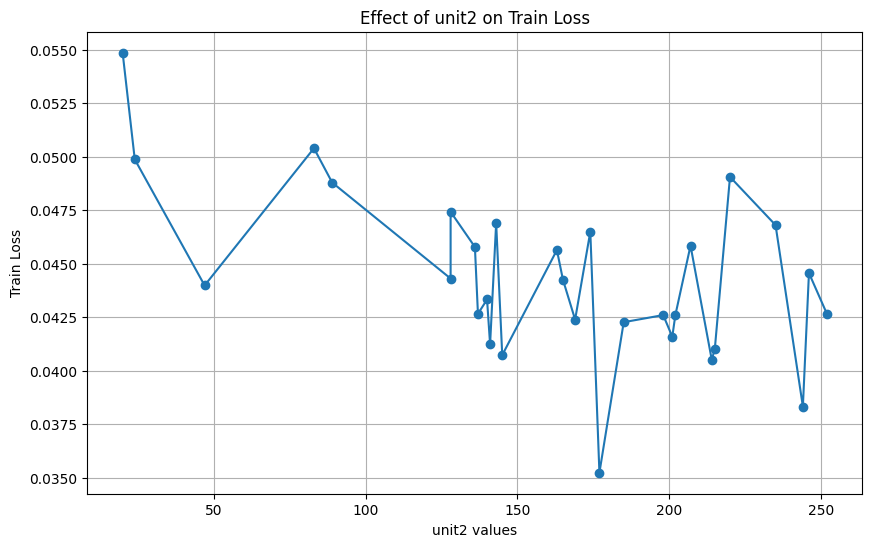

In [72]:
vis_obj_inst.line_plot(col_to_drop, 'unit2', 'Train Loss')

D3) We generate a scatterplot of the ratios to see if there is any special relationship between their ratios and the model's optimal performance

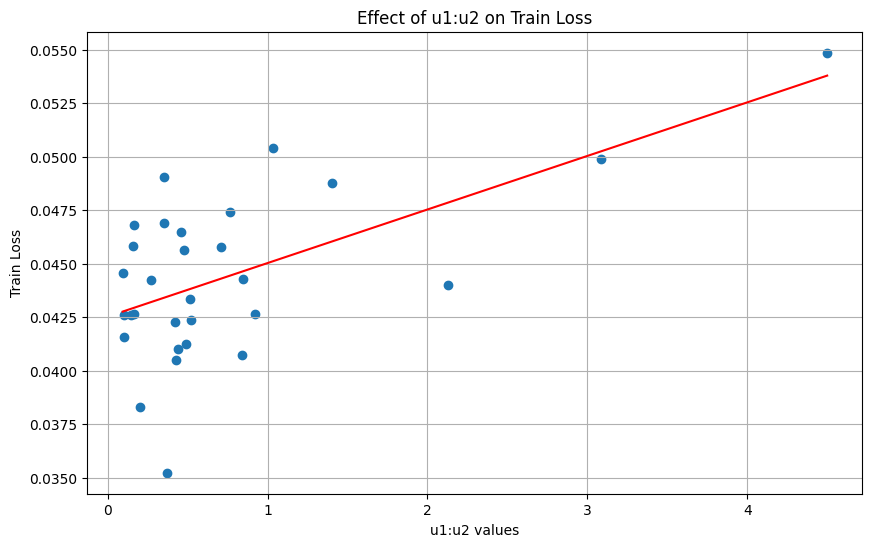

In [73]:
vis_obj_inst.scatter_plot(col_to_drop, 'u1:u2', 'Train Loss')

E) WE MOVE TO EXPLORE HOW TWO JOINT VARIABLES AFFECT THE MODEL'S RESULTING OUTPUT. WE DO THIS USING THE CONTOUR PLOT

E1) Calling the contour_plot_generator method from visualiser class on the vis_obj_inst to quickly visualise how any two variables in combination might affect the resulting model's overall performance. In the previous section, we looked into how the ratio of u1:u2 affected the resulting model's output. Now we get to look at this from the 2D perspective wi a layer of color hence contour plot. For the first part, we look at how unit1 and unit 2 sizes affect the resulting train loss and find that if our aim is to minimise the training loss, then our optimal point is the combination of unit 1 being around 70 and unit 2 around 170  

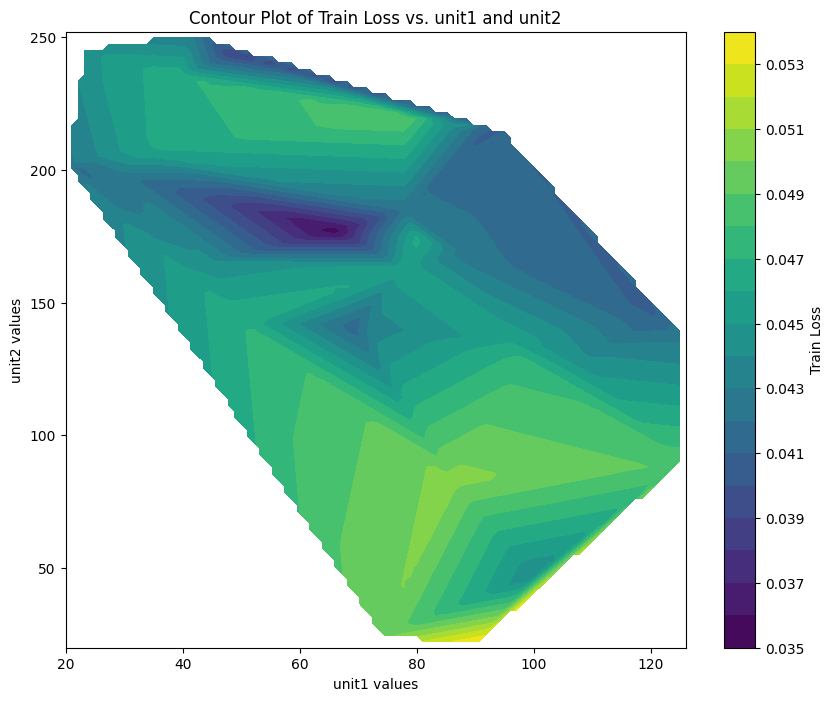

In [74]:
vis_obj_inst.two_D_contour_plot_(col_to_drop, 'unit1', 'unit2', 'Train Loss')

E2) Calling the contour_plot_generator method from visualiser class on the vis_obj_inst to quickly visualise how any two variables in combination might affect the resulting model's overall performance. For the second part, we look at how drop1 and drop 2 sizes affect the resulting train loss and find that if our aim is to minimise the training loss, then our optimal point is the combination of drop 1 being around 0.42 and drop 2 being almost 0  

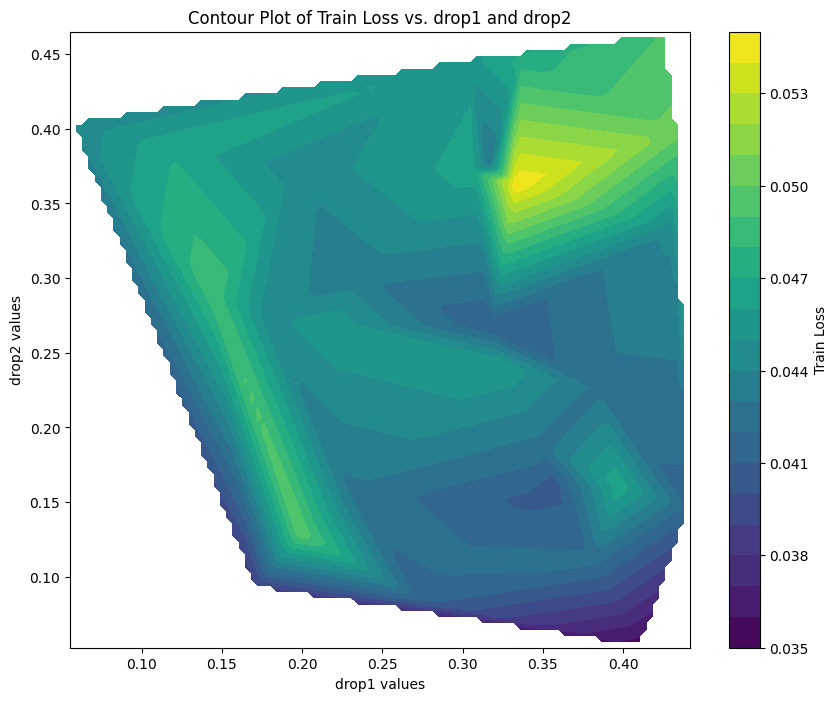

In [75]:
vis_obj_inst.two_D_contour_plot_(col_to_drop, 'drop1', 'drop2', 'Train Loss')

F) Now we move to attempt and understand how three variables affect the model. In the top three items that affected the model, we had u1:u2, d1:d2, and rate2. Let's see how these three, when combined, affect the model's perfomance so as to identify the optimal ratio, then we can go back to the 2D plot and identify the optimal combination that would give this ratio. This is the most we can combine the input parameters then run back to the 2D models to find where that optimal might lie

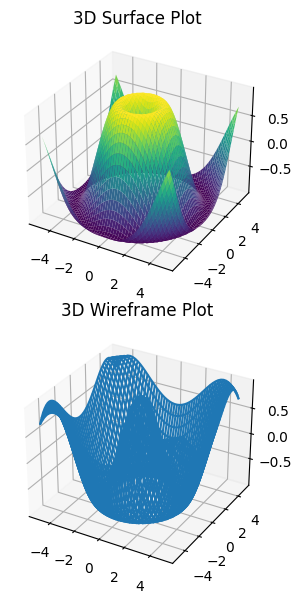

In [76]:
vis_obj_inst.three_D_contour_plot_(col_to_drop, 'u1:u2', 'd1:d2','drop2', 'Train Loss')

Preparing the test data for prediction

In [ ]:
#We begin by first transforming our test data
test = scaler.transform(np.array(test).reshape(-1,1))
print(test.reshape(-1)[0:5])

#Then we reshape it to fit into the model
X_test, y_test = split_sequence(test.reshape(-1), n_steps)

#Useful to understanding the new shaping
print('X_test data')
print('------------')
print(X_test.shape)
print(len(X_test[0]))
print(X_test[0][0:6])

print('y_test data')
print('------------')
print(y_test.shape)
print(len(y_test[0]))
print(y_test[0][0:6])

[0.29179068 0.29216632 0.27650475 0.24812899 0.22778629]
X_test data
------------
(365, 672)
672
[0.29179068 0.29216632 0.27650475 0.24812899 0.22778629 0.2171815 ]
y_test data
------------
(365, 48)
48
[0.27182362 0.28869882 0.2796833  0.24697316 0.21729708 0.19779235]


Performing the prediction

In [ ]:
# Then we use the new and transformed test dataset to perform the prediction
y_pred = uni_model.predict(X_test, verbose=0)
print(len(y_pred))

365


Then extracting the inverse

In [ ]:
y_out_pred_unscaled = scaler.inverse_transform(y_pred).flatten()
y_out_actual_unscaled = scaler.inverse_transform(y_test).flatten()
print(y_out_pred_unscaled.shape)
print(y_out_actual_unscaled.shape)
print(y_out_pred_unscaled[0:5])
print(y_out_actual_unscaled[0:5])

(17520,)
(17520,)
[17.580606 17.891703 17.541073 18.144194 17.975487]
[27.316 27.9   27.588 26.456 25.429]


In [ ]:
print(scaler.inverse_transform(y_test).flatten())

[27.316 27.9   27.588 ... 26.716 25.989 25.531]


Generate dates for the prediction set

In [ ]:
date = pd.to_datetime(df_demand['date'].iloc[split_point_two])
print(date)
print(type(date))
print(len((y_pred.flatten())))

#create an empty list onto which we will be appending all the generated timestamps
timestamps = []
#for loop to generate the timestamps of corresponding length to the dataframe and in timesteps of 30 minutes then append that data to the timestamps list
for i in range(0, len((y_pred.flatten()))*30, 30):
  timestamps.append(date + timedelta(minutes=i))

print(timestamps[0:5])
print(timestamps[-5:])
print(len(timestamps))

2017-01-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
17520
[Timestamp('2017-01-01 00:00:00'), Timestamp('2017-01-01 00:30:00'), Timestamp('2017-01-01 01:00:00'), Timestamp('2017-01-01 01:30:00'), Timestamp('2017-01-01 02:00:00')]
[Timestamp('2017-12-31 21:30:00'), Timestamp('2017-12-31 22:00:00'), Timestamp('2017-12-31 22:30:00'), Timestamp('2017-12-31 23:00:00'), Timestamp('2017-12-31 23:30:00')]
17520


In [ ]:
#The adding all of them to the new dataframe
df_prediction = pd.DataFrame(
    {'date': timestamps,
     'actual_demand':y_out_actual_unscaled,
     'pred_demand': y_out_pred_unscaled
    })

df_prediction.head()

,date,actual_demand,pred_demand
0,2017-01-01 00:00:00,27.316,17.580606
1,2017-01-01 00:30:00,27.900,17.891703
2,2017-01-01 01:00:00,27.588,17.541073
3,2017-01-01 01:30:00,26.456,18.144194
4,2017-01-01 02:00:00,25.429,17.975487


In [ ]:
import datetime

# df_demand = df_prediction
# print(len(df_demand))
# df_demand['predicted'] = (test[n_steps:])
# print(f'test_df_length:', len(df_demand))
df = df_prediction.copy()

df.set_index('date', inplace=True)

# # Resample the data to get weekly means and store them in a new dataframe
weekly_means = df['actual_demand'].resample('W').mean()
weekly_mean_df = pd.DataFrame({'week_mean': weekly_means})
weekly_means.head()
max_demand_date = weekly_mean_df.idxmax().iloc[0].date()
min_demand_date = weekly_mean_df.idxmin().iloc[0].date()

#Calculate the median date
sorted_data = weekly_mean_df['week_mean'].sort_values()

# Calculate the number of data points
num_data_points = len(sorted_data)

# Calculate the median value
if num_data_points % 2 == 1:
    # If the number of data points is odd, take the middle value
    median_index = num_data_points // 2
    median_value = sorted_data.iloc[median_index]
else:
    # If the number of data points is even, take the lower of the two middle values
    lower_middle_index = num_data_points // 2 - 1
    median_value = sorted_data.iloc[lower_middle_index]

# Print the median value
print("Median Value:", median_value)
median_date = weekly_mean_df.index[weekly_mean_df['week_mean'] == median_value]
median_dates = pd.to_datetime(median_date).date
print(median_dates)
med_demand_date = str(median_dates[0])
med_demand_date = datetime.datetime.strptime(med_demand_date, '%Y-%m-%d').date()


print(f'Max date is:',max_demand_date)
print(f'Min date is:',min_demand_date)
print(f'Median date is:',med_demand_date)
print(type(med_demand_date), type(min_demand_date))



max_week_df = df[df.index.isocalendar().week == max_demand_date.isocalendar().week]
min_week_df = df[df.index.isocalendar().week == min_demand_date.isocalendar().week]
med_week_df = df[df.index.isocalendar().week == med_demand_date.isocalendar().week]
print(len(max_week_df), len(min_week_df), len(med_week_df))


Median Value: 28.985761904761905
[datetime.date(2017, 10, 1)]
Max date is: 2017-01-29
Min date is: 2017-08-06
Median date is: 2017-10-01
<class 'datetime.date'> <class 'datetime.date'>
336 336 336


Performance on the maximum demand week

In [ ]:
mae_max_week = tf.keras.losses.MeanAbsoluteError()
mape_max_week= tf.keras.losses.mean_absolute_percentage_error(max_week_df['actual_demand'], max_week_df['pred_demand'])
rmse_max_week = tf.keras.metrics.RootMeanSquaredError()
print(f'MAE', mae_max_week(max_week_df['actual_demand'], max_week_df['pred_demand']).numpy())
print(f'MAPE', mape_max_week.numpy())
print(f'RMSE', rmse_max_week(max_week_df['actual_demand'], max_week_df['pred_demand']).numpy())

MAE 20.459915
MAPE 51.60697
RMSE 21.677816


Performance on median demand week

In [ ]:
mae_med_week = tf.keras.losses.MeanAbsoluteError()
mape_med_week= tf.keras.losses.mean_absolute_percentage_error(max_week_df['actual_demand'], max_week_df['pred_demand'])
rmse_med_week = tf.keras.metrics.RootMeanSquaredError()
print(f'MAE', mae_med_week(med_week_df['actual_demand'], med_week_df['pred_demand']).numpy())
print(f'MAPE', mape_med_week.numpy())
print(f'RMSE', rmse_med_week(med_week_df['actual_demand'], med_week_df['pred_demand']).numpy())

MAE 11.094439
MAPE 51.60697
RMSE 12.474884


Performance on minimum demand week

In [ ]:
mae_min_week = tf.keras.losses.MeanAbsoluteError()
mape_min_week= tf.keras.losses.mean_absolute_percentage_error(max_week_df['actual_demand'], max_week_df['pred_demand'])
rmse_min_week = tf.keras.metrics.RootMeanSquaredError()
print(f'MAE', mae_min_week(min_week_df['actual_demand'], min_week_df['pred_demand']).numpy())
print(f'MAPE', mape_min_week.numpy())
print(f'RMSE', rmse_min_week(min_week_df['actual_demand'], min_week_df['pred_demand']).numpy())

MAE 7.3335323
MAPE 51.60697
RMSE 8.478143


THE END

> Indented block

